<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imageio-ffmpeg

In [2]:
import jax.numpy as np
from jax import jit, grad, random
from jax.example_libraries import stax, optimizers

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio

rand_key = random.PRNGKey(0)

## Set up data

<ipython-input-3-0c7a8abf1ffe>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


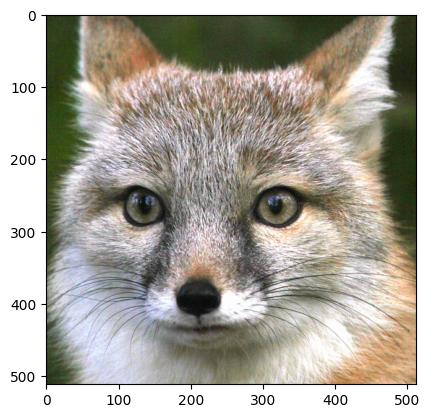

In [3]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2, ::2], img[::2, ::2]]

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

In [4]:
# Fourier feature mapping
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)


# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)


# Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data):

    init_fn, apply_fn = make_network(*network_size)

    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))
    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
    model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    model_grad_loss = jit(lambda params, x, y: grad(model_loss)(params, x, y))

    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)

    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }

## Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$.

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$.

<!-- - Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$.  -->

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$


In [5]:
network_size = (4, 256)
learning_rate = 1e-4
iters = 2000

mapping_size = 256

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plot results

In [ ]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [ ]:
# Save out video
all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=-2)
data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=1000 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))